In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
from collections import OrderedDict
sns.set()

# Preprocessing
from sklearn.preprocessing import QuantileTransformer
# Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram

from tools import *

DATA_DIR = Path('../../data')
PROC_DIR = Path(DATA_DIR / 'processed')
OUT_DIR = Path('./out/tsne')

if not OUT_DIR.exists():
    OUT_DIR.mkdir(parents=True) 

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']
MAX_CLUSTERS = 10

# Load data

In [2]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]'])

## Scale Inputs

In [3]:
scaled_flows = pd.DataFrame()
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='uniform', random_state=1)

scaled_flows = list(flows_dict.values())
scaled_flows = pd.concat(scaled_flows, axis=0)

scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)

scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())

(7533440, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.969273     0.680543
1  0.002002  0.969267     0.680292
2  0.004004  0.969261     0.680036
3  0.005907  0.969255     0.679774
4  0.008008  0.969249     0.679526


# Magnetic Field - B [G]

In [4]:
# separate into file series
scaled_magnetic = [scaled_flows['B [G]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['B [G]']) // 640)]
scaled_magnetic = np.array(scaled_magnetic)
scaled_magnetic[0][:5]

array([0.96927323, 0.96926717, 0.9692611 , 0.96925501, 0.96924891])

In [5]:
# # plot scaled magnetic field
# for b_line in scaled_magnetic:
#     plt.plot(b_line, linewidth=0.5)

## TSNE

In [20]:
tsne = TSNE(n_components=2, random_state=1)
transformed_mag = tsne.fit_transform(scaled_magnetic)
transformed_mag

array([[-39.387676,  53.068798],
       [ 23.758179,  45.430042],
       [ 51.343014,  34.074535],
       ...,
       [-33.751755, -70.02836 ],
       [ 37.53604 ,  26.65278 ],
       [ 11.336493, -26.500742]], dtype=float32)

<Axes: >

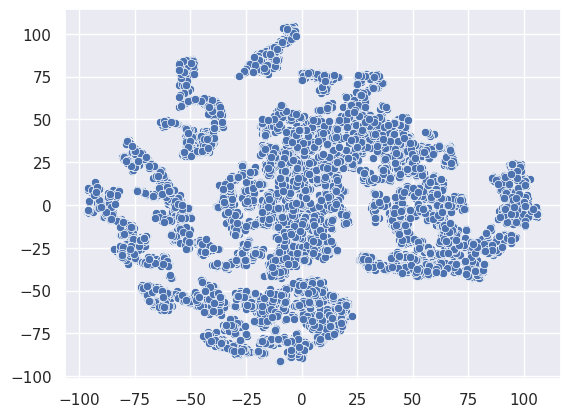

In [21]:
sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

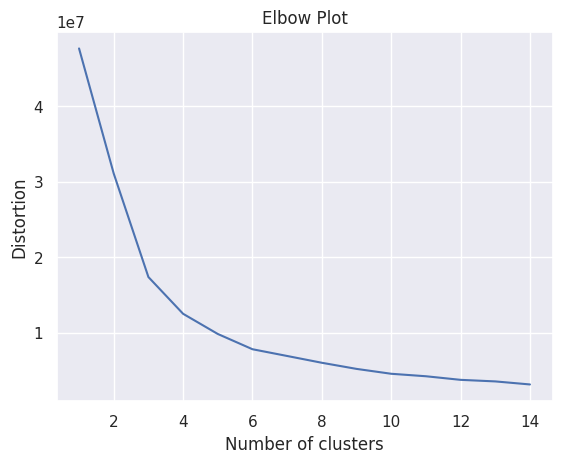

In [22]:
# Elbow Test
distortions = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto', random_state=1)
    kmeans.fit(transformed_mag)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [23]:
df = clustering_metrics(KMeans, transformed_mag, {"max_iter" : 5000, "n_init" : "auto", "random_state" : 1})
df

,K,S score,DB,CH
0,2,0.323015,1.264809,6275.825327
1,3,0.404495,0.863386,10259.410551
2,4,0.409095,0.838442,11029.297741
3,5,0.400490,0.867271,11319.886314
4,6,0.423564,0.756383,12010.234577
5,7,0.405706,0.831329,11557.171583
6,8,0.401582,0.797844,11639.115558
7,9,0.397177,0.792157,11998.942243
8,10,0.402551,0.785013,12363.612525


In [24]:
print(df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrr}
\toprule
K & S score & DB & CH \\
\midrule
2 & 0.323 & 1.265 & 6275.825 \\
3 & 0.404 & 0.863 & 10259.411 \\
4 & 0.409 & 0.838 & 11029.298 \\
5 & 0.400 & 0.867 & 11319.886 \\
6 & 0.424 & 0.756 & 12010.235 \\
7 & 0.406 & 0.831 & 11557.172 \\
8 & 0.402 & 0.798 & 11639.116 \\
9 & 0.397 & 0.792 & 11998.942 \\
10 & 0.403 & 0.785 & 12363.613 \\
\bottomrule
\end{tabular}



In [10]:
kmeans = KMeans(n_clusters=4,max_iter=5000, n_init='auto', random_state=1)

pca_kmeans_mag_labels = kmeans.fit_predict(transformed_mag)

<AxesSubplot: >

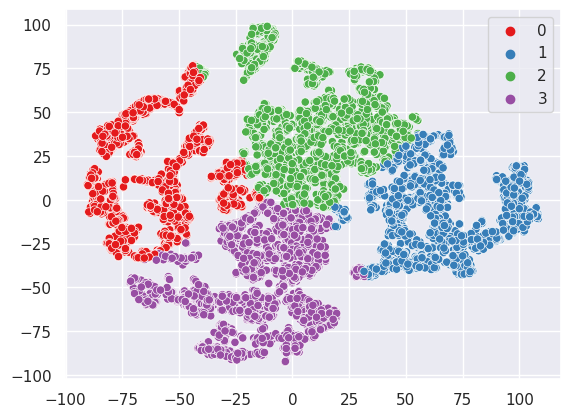

In [11]:
sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=pca_kmeans_mag_labels, palette='Set1')

### Original Data

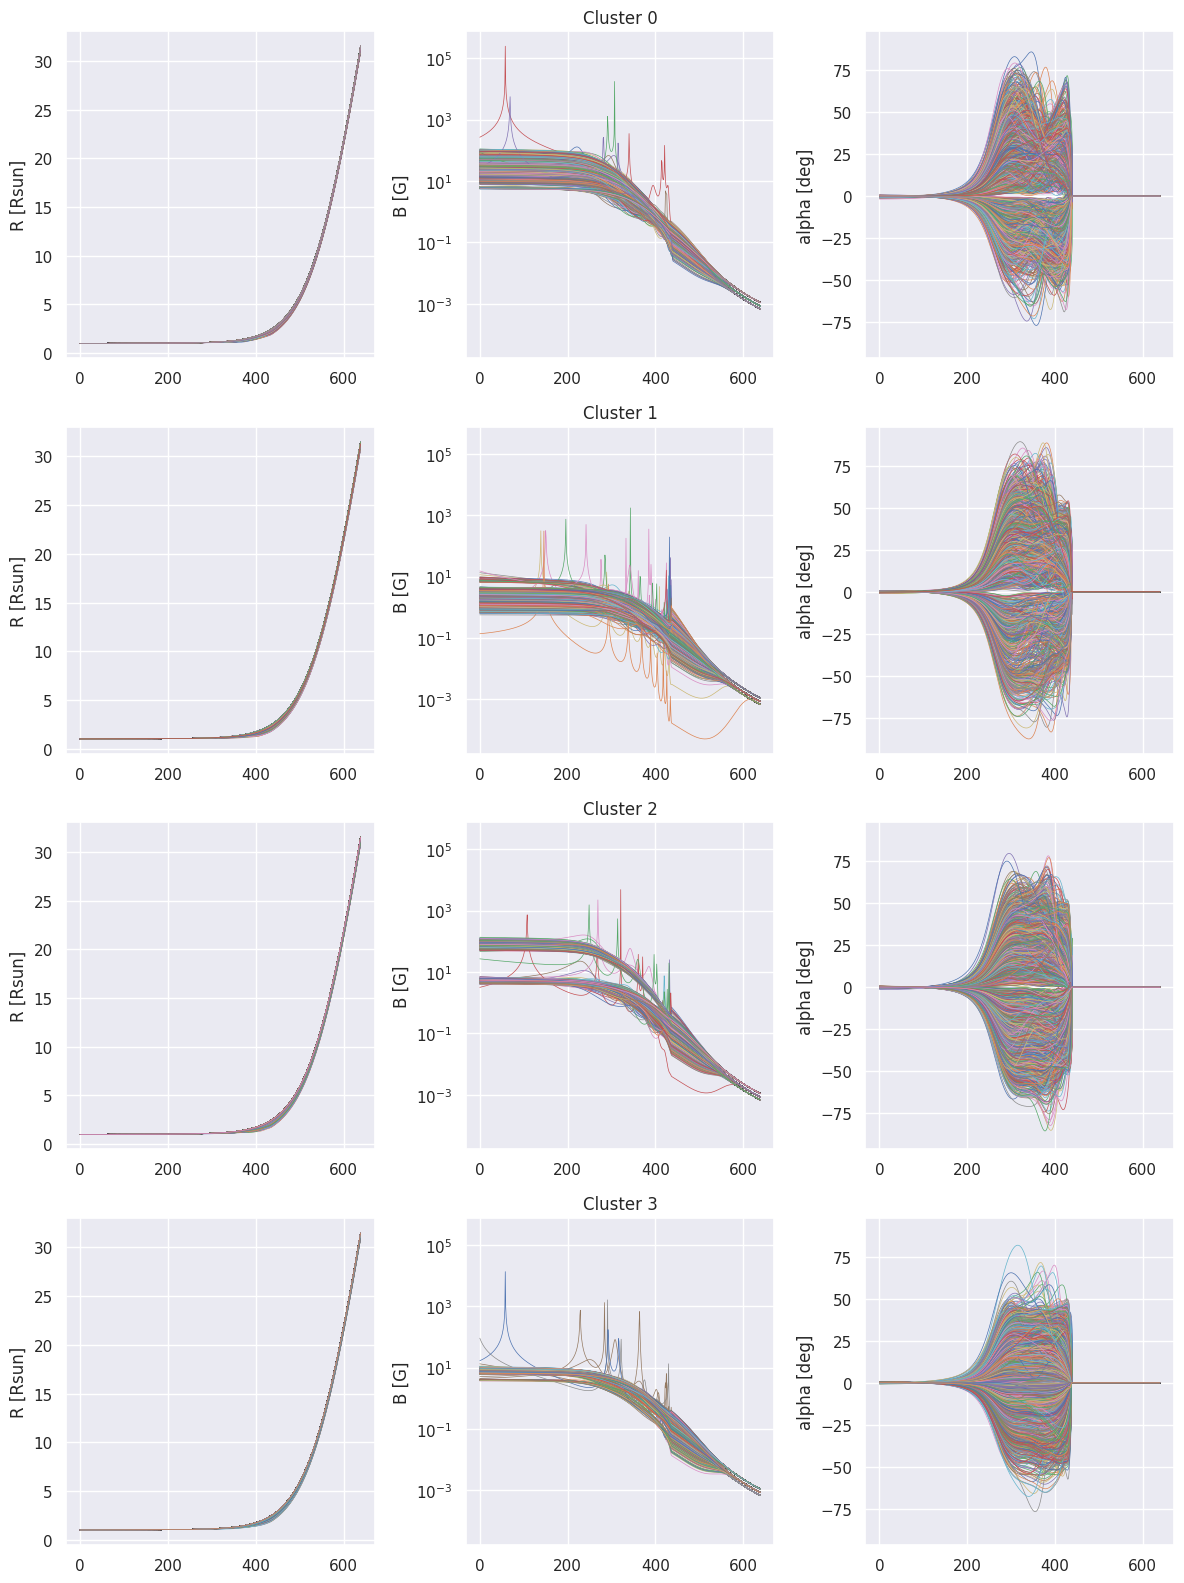

In [12]:
plot_unscaled_clusters(pca_kmeans_mag_labels, len(set(pca_kmeans_mag_labels)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

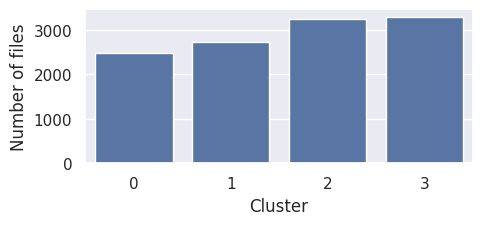

In [13]:
fig, ax = plt.subplots(figsize=(5, 2))
bp = sns.countplot(x=pca_kmeans_mag_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

## Hierarchical Clustering

In [27]:
df = clustering_metrics(AgglomerativeClustering, transformed_mag, {"linkage" : "ward", "compute_distances" : True, "compute_full_tree" : True})
df

,K,S score,DB,CH
0,2,0.360832,1.141236,7475.523551
1,3,0.348509,0.882580,7335.993360
2,4,0.385679,0.848407,9553.106672
3,5,0.386627,0.852929,10085.434615
4,6,0.390365,0.776777,10395.707581
5,7,0.357950,0.842102,10453.778161
6,8,0.346125,0.823260,10364.564959
7,9,0.356539,0.827150,10653.976115
8,10,0.372580,0.819691,11237.525457


In [28]:
print(df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrr}
\toprule
K & S score & DB & CH \\
\midrule
2 & 0.361 & 1.141 & 7475.524 \\
3 & 0.349 & 0.883 & 7335.993 \\
4 & 0.386 & 0.848 & 9553.107 \\
5 & 0.387 & 0.853 & 10085.435 \\
6 & 0.390 & 0.777 & 10395.708 \\
7 & 0.358 & 0.842 & 10453.778 \\
8 & 0.346 & 0.823 & 10364.565 \\
9 & 0.357 & 0.827 & 10653.976 \\
10 & 0.373 & 0.820 & 11237.525 \\
\bottomrule
\end{tabular}



In [14]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=2, compute_full_tree=True, linkage='ward')
agg = agg.fit(transformed_mag)

Text(0.5, 0, 'Number of points in node')

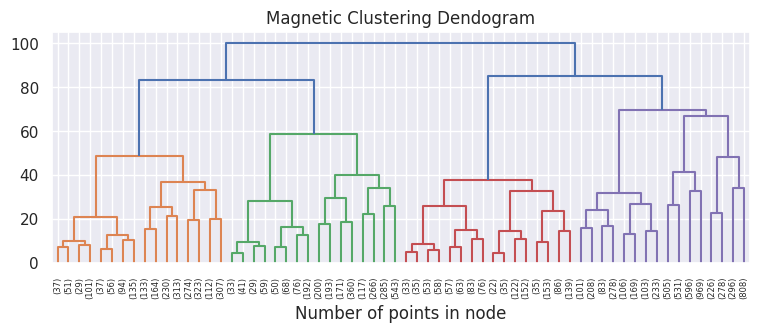

In [15]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=5)
plt.xlabel("Number of points in node")

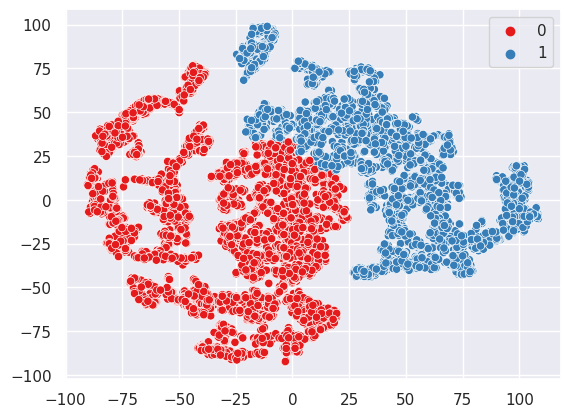

In [16]:
sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

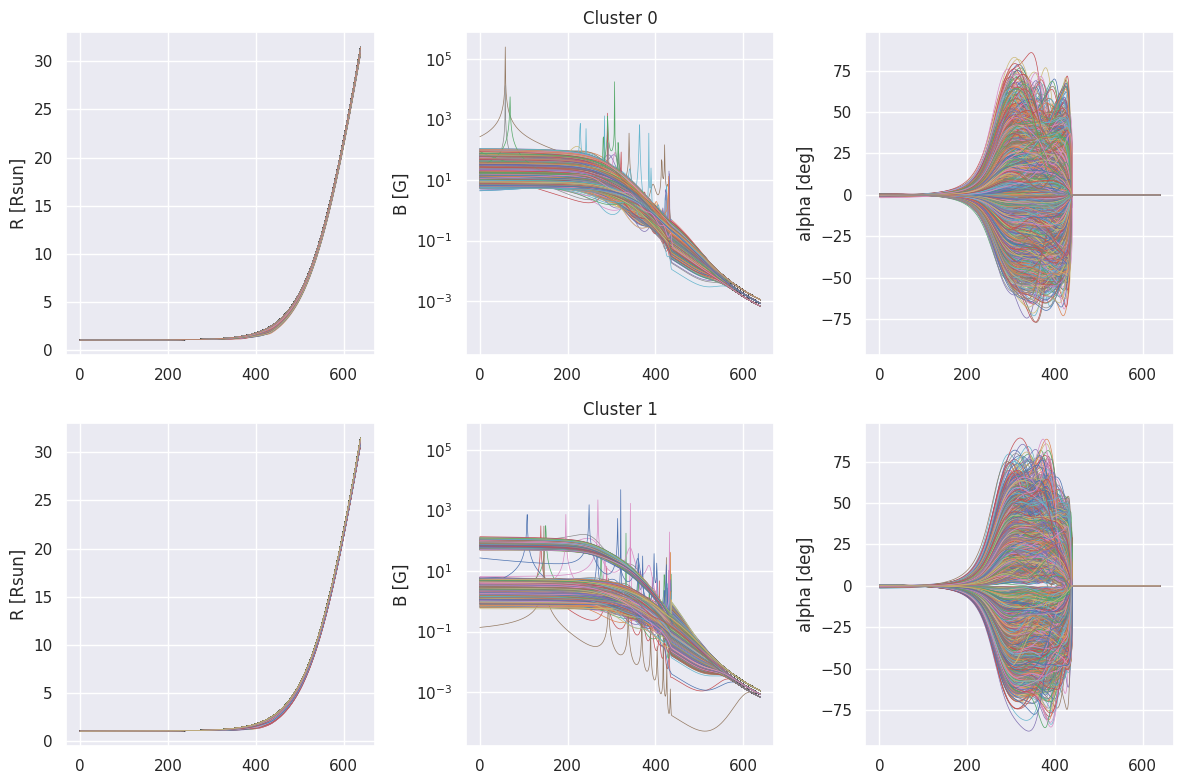

In [17]:
plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

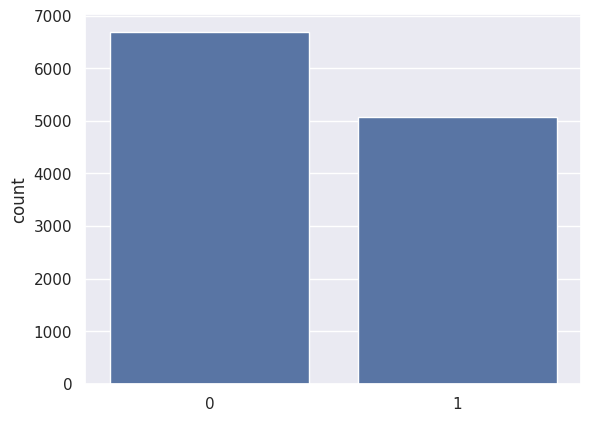

In [18]:
sns.countplot(x=agg.labels_, color='b')

In [19]:
# %%capture
# sub_dir = OUT_DIR / 'mag'
# if not sub_dir.exists():
#     sub_dir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_mag)
    
#     sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=agg.labels_, palette='Set1')
    
        
#     plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, 
#                            save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png', yscale={'B [G]': 'log'})
    

# Flux Tube Inclination - alpha [deg]

In [29]:
# separate into file series
scaled_alpha = [scaled_flows['alpha [deg]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['alpha [deg]']) // 640)]
scaled_alpha = np.array(scaled_alpha)
scaled_alpha[0][:5]


array([0.68054308, 0.68029178, 0.68003552, 0.67977423, 0.67952554])

## TSNE

In [30]:
tsne = TSNE(n_components=2, random_state=1)
transformed_alpha = tsne.fit_transform(scaled_alpha)
transformed_alpha


array([[ 86.23837  , -20.126192 ],
       [-72.78739  ,  27.41511  ],
       [-62.765656 , -41.497387 ],
       ...,
       [ -9.890353 ,  33.71424  ],
       [ 10.963002 ,  51.843124 ],
       [-73.64408  ,  -0.7440127]], dtype=float32)

### Transformed

<AxesSubplot: >

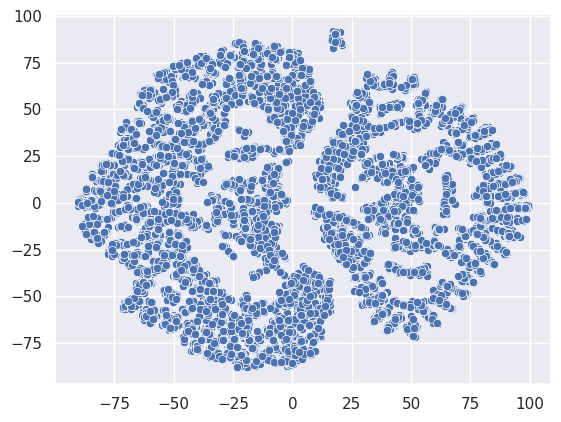

In [22]:
sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

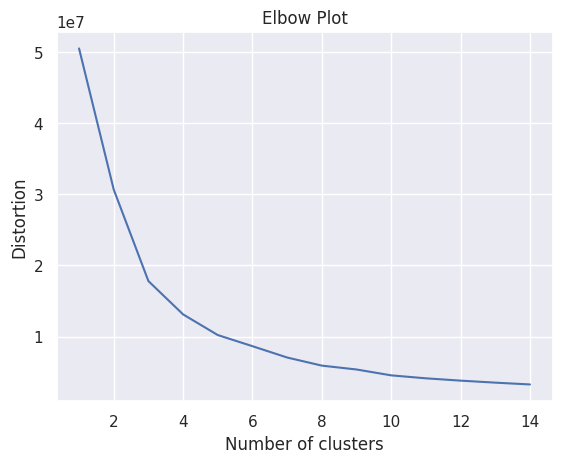

In [31]:
# Elbow Test
distortions = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto', random_state=1)
    kmeans.fit(transformed_alpha)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [32]:
df = clustering_metrics(KMeans, transformed_alpha, {"max_iter" : 5000, "n_init" : "auto", "random_state" : 1})
df

,K,S score,DB,CH
0,2,0.366924,1.142181,7613.630294
1,3,0.410485,0.802874,10814.209489
2,4,0.389199,0.817316,11185.704927
3,5,0.382298,0.876714,11611.815697
4,6,0.365000,0.865536,11396.260678
5,7,0.396369,0.779272,12086.747724
6,8,0.394222,0.754217,12678.408124
7,9,0.394793,0.776221,12365.808115
8,10,0.397877,0.789430,13223.490047


In [33]:
print(df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrr}
\toprule
K & S score & DB & CH \\
\midrule
2 & 0.367 & 1.142 & 7613.630 \\
3 & 0.410 & 0.803 & 10814.209 \\
4 & 0.389 & 0.817 & 11185.705 \\
5 & 0.382 & 0.877 & 11611.816 \\
6 & 0.365 & 0.866 & 11396.261 \\
7 & 0.396 & 0.779 & 12086.748 \\
8 & 0.394 & 0.754 & 12678.408 \\
9 & 0.395 & 0.776 & 12365.808 \\
10 & 0.398 & 0.789 & 13223.490 \\
\bottomrule
\end{tabular}



In [25]:
kmeans = KMeans(n_clusters=3,max_iter=5000, n_init='auto', random_state=1)

pca_kmeans_alpha_labels = kmeans.fit_predict(transformed_alpha)

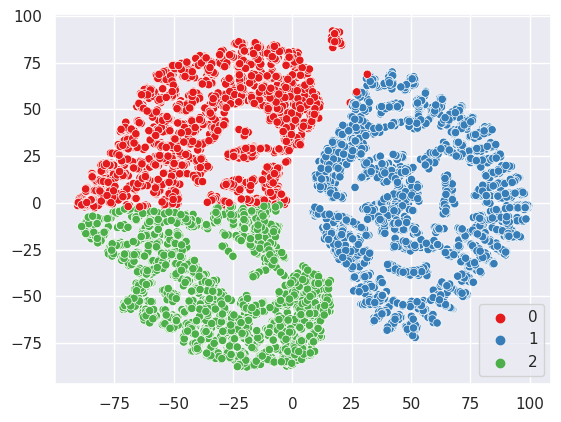

In [26]:
sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=pca_kmeans_alpha_labels, palette='Set1')
plt.legend(loc='lower right')

### Original Data

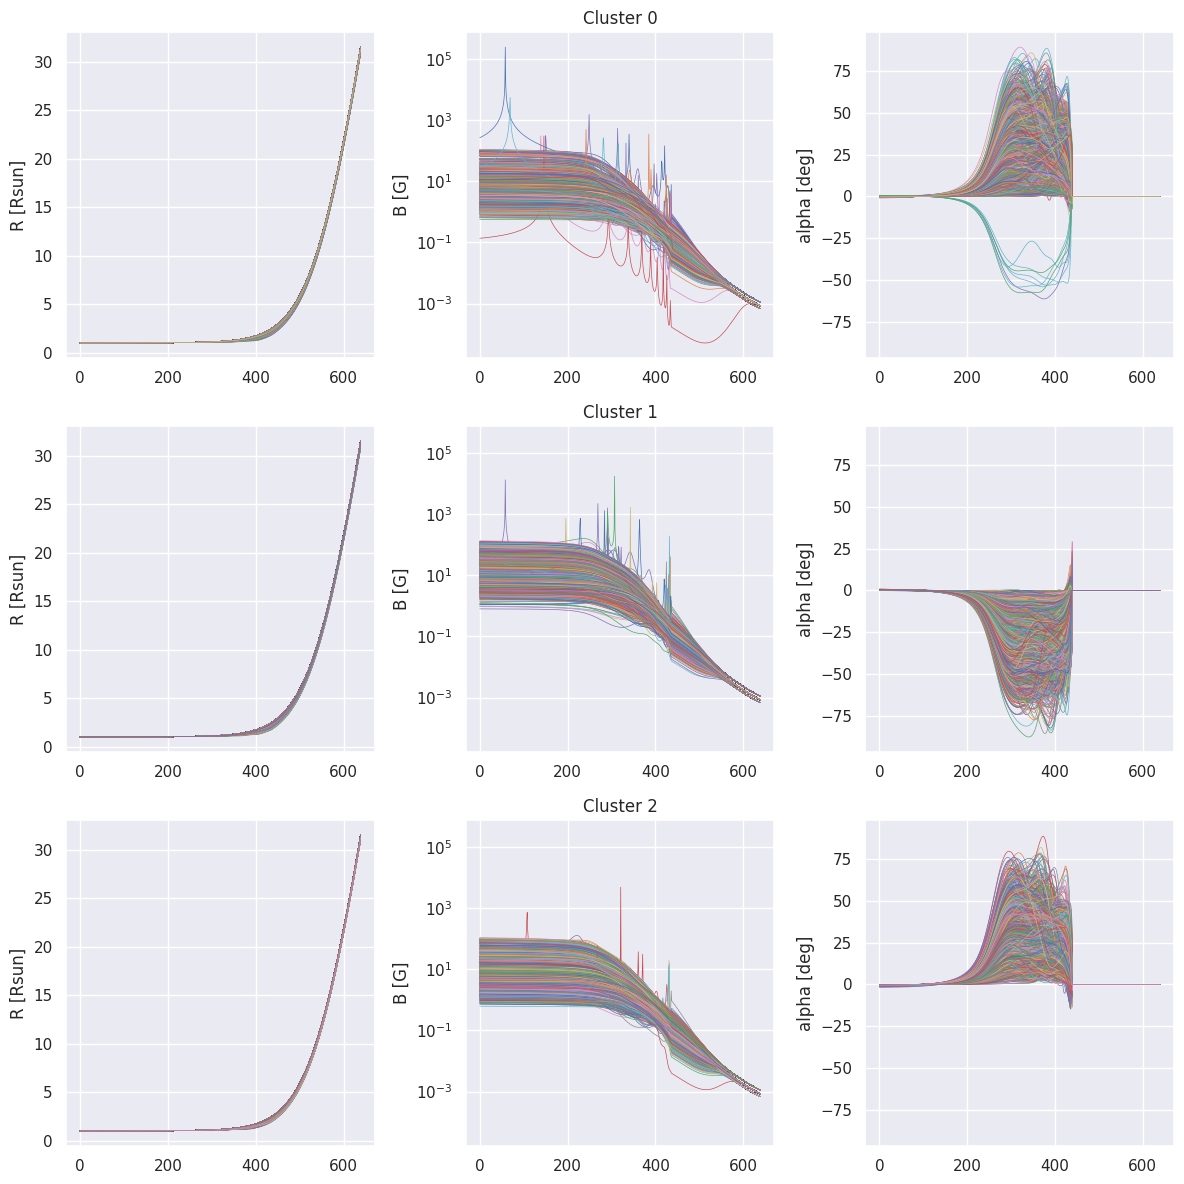

In [27]:
plot_unscaled_clusters(pca_kmeans_alpha_labels, len(set(pca_kmeans_alpha_labels)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

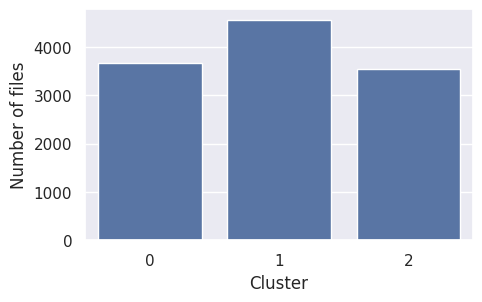

In [28]:
fig, ax = plt.subplots(figsize=(5, 3))
bp = sns.countplot(x=pca_kmeans_alpha_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

## Hierarchical Clustering

In [34]:
df = clustering_metrics(AgglomerativeClustering, transformed_alpha, {"linkage" : "ward", "compute_distances" : True, "compute_full_tree" : True})
df

,K,S score,DB,CH
0,2,0.342893,1.111756,6787.067535
1,3,0.384719,0.864205,9815.034552
2,4,0.350019,0.887313,8899.700898
3,5,0.335816,0.944912,9269.538834
4,6,0.366098,0.867367,9925.395820
5,7,0.350514,0.860608,10223.738699
6,8,0.338402,0.798716,10276.151508
7,9,0.324804,0.785076,10429.012161
8,10,0.341123,0.853260,10870.185109


In [36]:
print(df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrr}
\toprule
K & S score & DB & CH \\
\midrule
2 & 0.343 & 1.112 & 6787.068 \\
3 & 0.385 & 0.864 & 9815.035 \\
4 & 0.350 & 0.887 & 8899.701 \\
5 & 0.336 & 0.945 & 9269.539 \\
6 & 0.366 & 0.867 & 9925.396 \\
7 & 0.351 & 0.861 & 10223.739 \\
8 & 0.338 & 0.799 & 10276.152 \\
9 & 0.325 & 0.785 & 10429.012 \\
10 & 0.341 & 0.853 & 10870.185 \\
\bottomrule
\end{tabular}



In [29]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=2, compute_full_tree=True, linkage='ward')

agg = agg.fit(transformed_alpha)

Text(0.5, 0, 'Number of points in node')

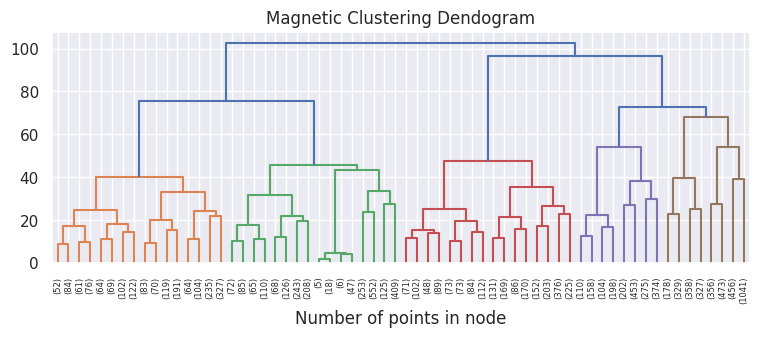

In [30]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=5)
plt.xlabel("Number of points in node")

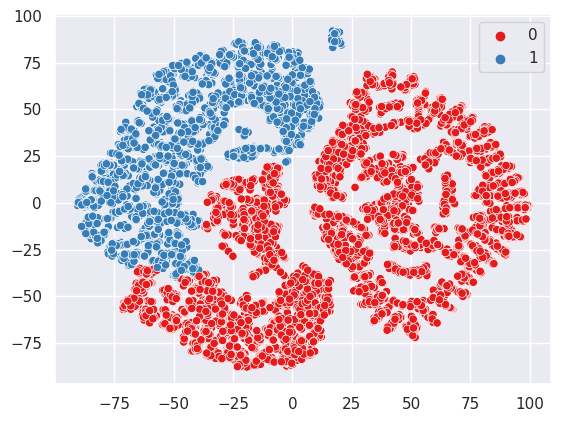

In [31]:
sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

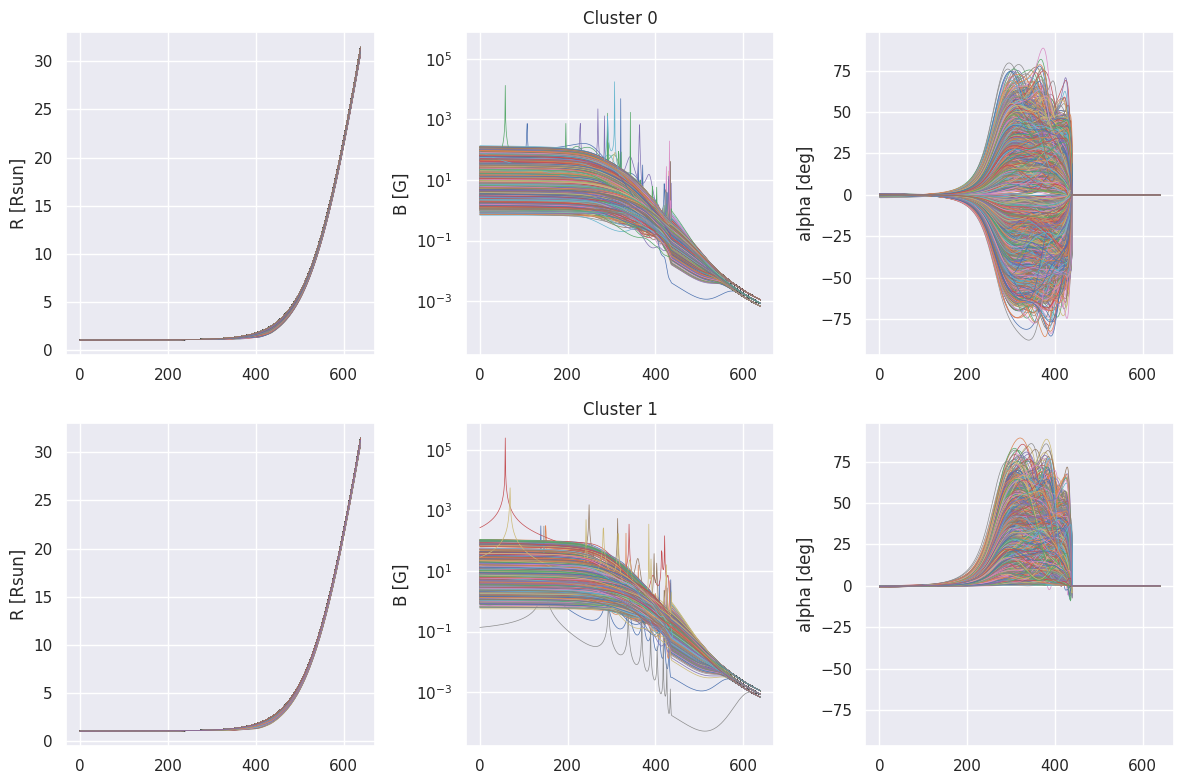

In [32]:
plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

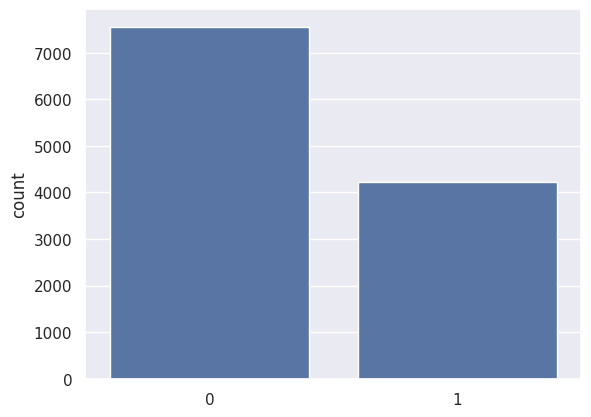

In [33]:
sns.countplot(x=agg.labels_, color='b')

In [34]:
# %%capture
# sub_dir = OUT_DIR / 'alpha'
# if not sub_dir.exists():
#     sub_dir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_alpha)
    
#     sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=agg.labels_, palette='Set1')
    
        
#     plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, 
#                            save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png', yscale={'B [G]': 'log'}) 
    